In [1]:
import torch as t
import matplotlib.pyplot as plt

In [180]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	10,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  20,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [8]:
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [276]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [181]:
exp_path = os.path.join(dir_path,'Plotting','tmp_UE0s')
params_dict.update({"exp_path":exp_path})

(0.0, 1.0257789462804794)

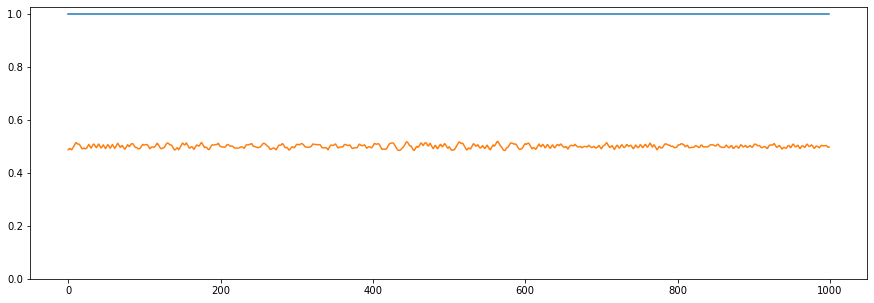

In [186]:
# alpha_path = os.path.join(dir_path,'Experiments','Flensmon2D_6','SymAlpha_XGate_alphas.pt')
# controls = t.zeros(params_dict['NTrot'])
# alphas = t.load(alpha_path)

control_path = os.path.join(dir_path,'Experiments','Flensmon2D_4','22_09_0955_pulse.pt')
control = t.load(control_path)
alphas = t.ones(params_dict['NTrot'])

plt.figure(figsize=(15,5))
plt.plot(alphas)
plt.plot(control+0.5)
plt.ylim(0,None)

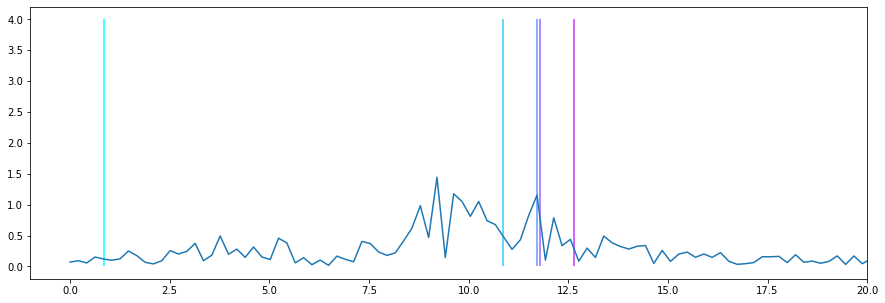

In [283]:
eigvals = ET.H0_term[500].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]

fft = t.fft.rfft(control)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(t.linspace(0,t.pi/ET.dt,ET.NTrot//2+1),fft.abs())
ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))

In [277]:
def get_classes(params_dict=params_dict,alphas=alphas):
    class QTrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
        def __init__(self,params_dict):
            super().__init__()
            self.params_dict = params_dict
            self.alphas = alphas
            self.control = control
            super(t.nn.Module,self).__init__()
            return

        def forward(self):
            H = self.get_H(self.activation_func(self.times),self.get_control())
            self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
            return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
        
        def V_2d(self, alphas, control):
            return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                                - alphas.view(-1,1,1)*self.cos2_mat \
                                + control.view(-1,1,1)*self.q_mat)

    class ETrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.ETrotter, Plotting.Plotter):
        def __init__(self,params_dict):
            super().__init__()
            self.params_dict = params_dict
            self.alphas = alphas
            self.control = control
            super(t.nn.Module,self).__init__()
            return

        def forward(self):
            H = self.get_H(self.activation_func(self.times),self.control)
            self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
            return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
        
        def V_2d(self, alphas, control):
            return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                                - alphas.view(-1,1,1)*self.cos2_mat \
                                + control.view(-1,1,1)*self.q_mat)

    class SavedBasis(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.SavedBasis, Plotting.Plotter):
        def __init__(self,params_dict):
            super().__init__()
            self.params_dict = params_dict
            self.alphas = alphas
            self.control = control
            super(t.nn.Module,self).__init__()
            return

        def forward(self):
            H = self.get_H(self.activation_func(self.times),self.get_control())
            self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
            return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
        
        def V_2d(self, alphas, control):
            return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                                - alphas.view(-1,1,1)*self.cos2_mat \
                                + control.view(-1,1,1)*self.q_mat)

    QT = QTrotter(params_dict)
    SB = SavedBasis(params_dict)
    ET = ETrotter(params_dict)

    return QT, ET, SB

In [278]:
def get_occs(*classes,getQTocc = False):
    from tqdm import tqdm
    if classes:
        QT, ET, SB = classes
    else:
        QT, ET, SB = get_classes()

    U0s, E0s = ET.load_UE0s()
    
    ET()
    occET = ET.get_occupancy([_ for _ in range(ET.subNHilbert)],[0,1]).detach()

    # Hs = SB.get_H(SB.alphas)
    occSB = t.zeros_like(occET)
    bitesize = 100
    bites = t.arange(0,SB.NTrot+bitesize,bitesize)
    SBevo = SB.init_wavefuncs[:,[0,1]]
    for i in tqdm(range(bites.shape[0]-1)):
        # H = Hs[bites[i]:bites[i+1]]
        H = SB.get_H(SB.alphas[bites[i]:bites[i+1]],SB.control[bites[i]:bites[i+1]])
        exp_mat = t.matrix_exp(-1j*H*SB.dt)
        for j in range(exp_mat.shape[0]):
            index = i*bitesize + j
            SBevo = exp_mat[j]@SBevo
            occSB[:-1,index] = (U0s[index].adjoint()@SB.basis@SBevo).abs().square()
    occSB[-1] = 1 - occSB.sum(0)

    if getQTocc:
        # Hs = QT.get_H(QT.alphas)
        occQT = t.zeros_like(occET)
        bitesize = 100
        bites = t.arange(0,QT.NTrot+bitesize,bitesize)
        QTevo = QT.eigvecs[:,[0,1]]
        for i in tqdm(range(bites.shape[0]-1)):
            # H = Hs[bites[i]:bites[i+1]]
            H = QT.get_H(QT.alphas[bites[i]:bites[i+1]],QT.control[bites[i]:bites[i+1]])
            exp_mat = t.matrix_exp(-1j*H*QT.dt)
            for j in range(exp_mat.shape[0]):
                index = i*bitesize + j
                QTevo = exp_mat[j]@QTevo
                occQT[:-1,index] = (U0s[index].adjoint()@QTevo).abs().square()
        occQT[-1] = 1 - occSB.sum(0)
        return occET, occSB, occQT
    else:
        return occET, occSB   


In [279]:
QT, ET, SB  = get_classes()
occET, occSB = get_occs(QT,ET,SB,getQTocc=False)
# occET, occSB, occQT = get_occs(QT,ET,SB,getQTocc=True)

I added a factor half to the cosines
I added a factor half to the cosines
I added a factor half to the cosines
Loaded UE0s


100%|██████████| 10/10 [00:00<00:00, 22.10it/s]


In [211]:
alphas2 = ET.init_activation_func(ET.times)
QT2, ET2, SB2 = get_classes(alphas=alphas2)
# occET2, occSB2 = get_occs(QT2,ET2,SB2)
occET2, occSB2, occQT2 = get_occs(QT2,ET2,SB2,getQTocc=True)

In [272]:
def plot(occ,occ2,ET=ET):
    fontsize=20
    occ_labels = [r"$\psi_{"+str(i)+r"}$" if i in [0,1,2,4,5] else None for i in range(ET.subNHilbert)]
    occ_labels[0] + "\n"+r"$|\psi_0|^2 = $"+str(occ[0,-1,0].item())[:7]

    fig, ax = plt.subplots(figsize=(20,40),nrows=5)

    new = alphas
    old = alphas2#ET2.init_activation_func(ET.times)
    # ax[0].plot(ET.times,new,label=r'Optimized Alphas: $\alpha_{opt}(t)$')#+'\n'+r'max$(|\alpha_{opt}(t) - \alpha_{opt}(-t)|) = 4\cdot 10^{-4}$')
    # ax[0].plot(obj2.times,obj2.alphas,linestyle='--')
    ax[0].plot(ET.times,old,label=r'Original Alphas: $\alpha_0(t)$')
    # ax[0].plot(ET.times,new-old+0.5,label=r'Difference: $\alpha_{opt}(t) - \alpha_0(t)$')
    ax[0].plot(ET.times,ET.control*10+0.7,label=r'Control Pulse $u(t)$'+'\n(no y-axis)')
    ax[0].hlines(0.7,0,30,linestyle='--',color='k',zorder=-1)
    ax[0].legend(fontsize=fontsize,loc=1)
    ax[0].set_title(r"The control pulse $u(t)$ from $t=0ns$ to $t=T=30ns$ for $\alpha = 1$ with max$(E_J\Delta u)\leq 0.005E_J$" +"\n" + r"Simulated using $N_{Trotter} = 1000$ and $q_{max}=10$, also optimized for shortest gate.",fontsize=fontsize)
    # ax[0].set_title(r"The time dependent $\alpha$ from $t=0ns$ to $t=T=30ns$" +"\n" + r"Simulated using $N_{Trotter} = 1000$ and $q_{max}=10$",fontsize=fontsize)

    # ax[1].plot(obj.times[:500],new[:500])
    # ax[1].plot(obj.times[:500],new[500:].flip(0))
    # ax[1].plot(obj.times[:500],t.abs(new[:500] - new[500:].flip(0)))
    # ax[1].set_yscale('log')

    occ_labels = [r"$\psi_{"+str(i)+r"}$" if i in [0,1,2,3,6,7,12,13,18] else None for i in range(ET.subNHilbert)]
    occ_labels[0] += " with "+r"$|\langle \psi_0(T) |\mathcal{U}(T)| \psi_0(0)\rangle|^2 = $"+f"{occ[0,-1,0].item():.5f}"
    occ_labels[1] += " with "+r"$|\langle \psi_1(T) |\mathcal{U}(T)| \psi_0(0)\rangle|^2 = $"+f"{occ[1,-1,0].item():.5f}"

    ax[1].plot(ET.times,occ[:-1,:,0].T,label=occ_labels)
    ax[1].plot(ET.times,occ[-1,:,0],'k--',zorder=-1)
    ax[1].legend(fontsize=fontsize,framealpha=0.2)
    ax[1].set_title(r"$|\langle \psi_n(t) |\mathcal{U}(t)| \psi_0(0)\rangle|^2$ with $\psi_n(t)$ being the adiabatic evolution of the n'th energy level for $\alpha=1$",fontsize=fontsize)
    # ax[1].hlines(1,0,30,zorder=-1,linestyle='--',color='k')
    # ax[1].set_ylim(1e-4,1.1)
    # ax[1].set_yscale('log')

    occ_labels = [r"$\psi_{"+str(i)+r"}$" if i in [0,1,2,3,6,7,12,13,18] else None for i in range(ET.subNHilbert)]
    occ_labels[0] += " with "+r"$|\langle \psi_0(T) |\mathcal{U}(T)| \psi_1(0)\rangle|^2 = $"+f"{occ[0,-1,1].item():.5f}"
    occ_labels[1] += " with "+r"$|\langle \psi_1(T) |\mathcal{U}(T)| \psi_1(0)\rangle|^2 = $"+f"{occ[1,-1,1].item():.5f}"

    ax[2].plot(ET.times,occ[:-1,:,1].T,label=occ_labels)
    ax[2].plot(ET.times,occ[-1,:,1],'k--',zorder=-1)
    ax[2].legend(fontsize=fontsize,framealpha=0.2)
    ax[2].set_title(r"$|\langle \psi_n(t) |\mathcal{U}(t)| \psi_1(0)\rangle|^2$",fontsize=fontsize)

    occ_labels = [r"$\psi_{"+str(i)+r"}$" if i in [0,1] else None for i in range(ET.subNHilbert)]
    occ_labels[0] += " with "+r"$|\langle \psi_0(T) |\mathcal{U}(T)| \psi_0(0)\rangle|^2 = $"+str(occ2[0,-1,0].item())[:7]
    occ_labels[1] += " with "+r"$|\langle \psi_1(T) |\mathcal{U}(T)| \psi_0(0)\rangle|^2 = $"+str(occ2[1,-1,0].item())[:7]

    ax[3].plot(ET.times,occ2[:-1,:,0].T,label=occ_labels)
    ax[3].set_prop_cycle(None)
    ax[3].plot(ET.times,occ[:-1,:,0].T,linestyle='--')
    # ax[3].plot(obj4.times,occ11[:-1,:,0].T,linestyle='--')
    ax[3].plot(ET.times,occ2[-1,:,0],'k--',zorder=-1)
    ax[3].legend(fontsize=fontsize)
    ax[3].set_title(r"$|\langle \psi_n(t) |\mathcal{U}(t)| \psi_0(0)\rangle|^2$ simulated using the instantaneous basis, which is used during optimization.",fontsize=fontsize)

    occ_labels = [r"$\psi_{"+str(i)+r"}$" if i in [0,1] else None for i in range(ET.subNHilbert)]
    occ_labels[0] += " with "+r"$|\langle \psi_0(T) |\mathcal{U}(T)| \psi_1(0)\rangle|^2 = $"+str(occ2[0,-1,1].item())[:7]
    occ_labels[1] += " with "+r"$|\langle \psi_1(T) |\mathcal{U}(T)| \psi_1(0)\rangle|^2 = $"+str(occ2[1,-1,1].item())[:7]

    ax[4].plot(ET.times,occ2[:-1,:,1].T,label=occ_labels)
    ax[4].set_prop_cycle(None)
    ax[4].plot(ET.times,occ[:-1,:,1].T,linestyle='--')
    # ax[4].plot(obj3.times,occ6[:-1,:,1].T,linestyle='--')
    # ax[4].plot(obj3.times,occ9[:-1,:,1].T,linestyle='--')
    ax[4].plot(ET.times,occ2[-1,:,1],'k--',zorder=-1)
    ax[4].legend(fontsize=fontsize)
    ax[4].set_title(r"$|\langle \psi_n(t) |\mathcal{U}(t)| \psi_1(0)\rangle|^2$",fontsize=fontsize)
    return fig

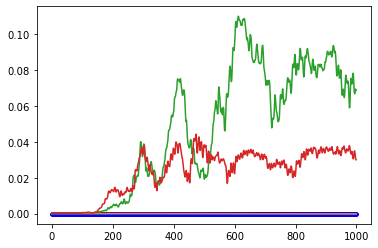

In [284]:
plt.plot(occQT[-1,:],'b.');
plt.plot(occET[-1,:]);
plt.plot(occSB[-1,:]);

In [415]:
H = QT.get_H(alphas=t.tensor([1.0]),control=t.tensor([0.0])).squeeze()
eigvals, eigvecs = t.linalg.eigh(H)

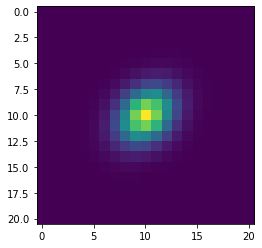

In [416]:
plt.imshow(eigvecs[:,0].abs().view(21,21))

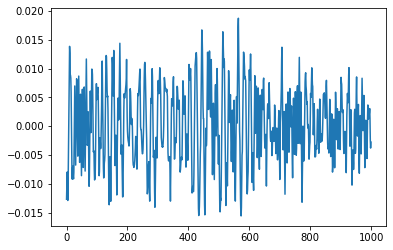

In [412]:
plt.plot(control)

In [420]:
params_dict['EJ']*0.4/(8*params_dict['EC']), (8*params_dict['EC'])*10/params_dict['EJ'], (8*params_dict['EC'])/params_dict['EJ']

(5.0, 0.8, 0.08)

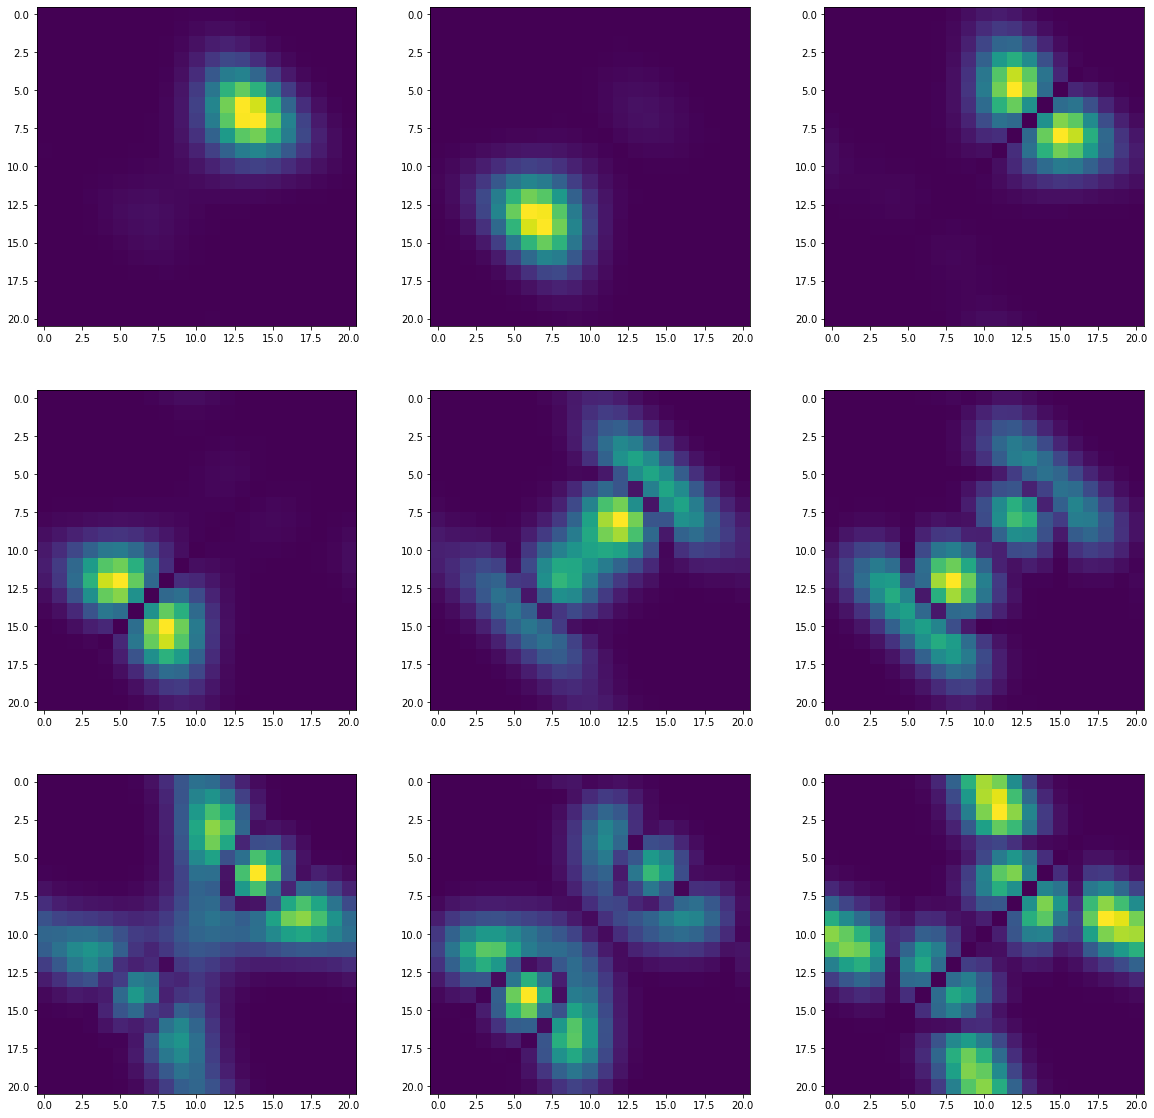

In [419]:
fig, ax = plt.subplots(figsize=(20,20),ncols=3,nrows=3)
ax = ax.flatten()
for i in range(ax.shape[0]):
    ax[i].imshow(t.fft.fftshift(t.fft.ifft2(t.fft.ifftshift(eigvecs[:,i].view(21,21))).abs()))
    # ax[i].imshow(eigvecs[:,i].view(21,21).abs())

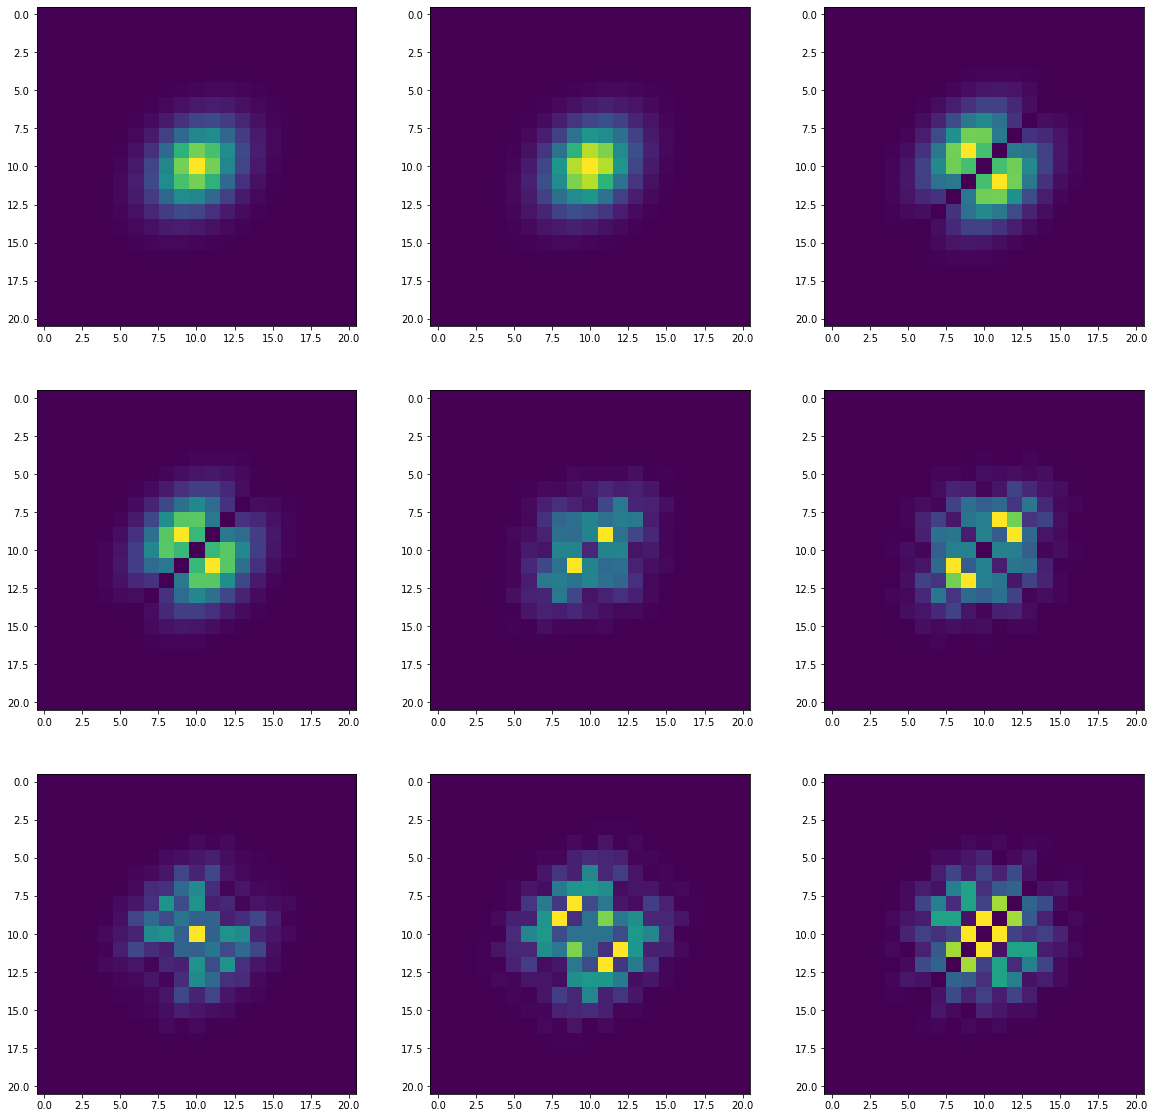

In [406]:
# plt.imshow(t.fft.ifftshift(t.fft.ifft2(eigvecs[:,0].view(21,21)).abs()))
fig, ax = plt.subplots(figsize=(20,20),ncols=3,nrows=3)
ax = ax.flatten()
for i in range(ax.shape[0]):
    # ax[i].imshow(t.fft.fftshift(t.fft.ifft2(t.fft.ifftshift(eigvecs[:,i].view(21,21))).abs()))
    ax[i].imshow(eigvecs[:,i].view(21,21).abs())

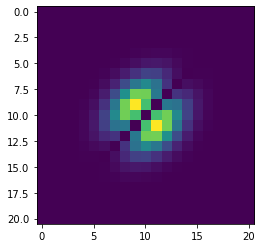

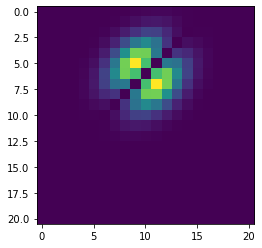

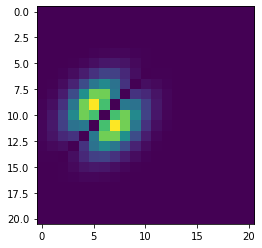

In [358]:
# plt.figure(figsize=(15,5))
# plt.plot(SB.basis.abs()[:,7]);

plt.imshow(QT.eigvecs[:,2].abs().view(21,21))
plt.figure()
plt.imshow(t.diag(t.ones(17),-4).T@QT.eigvecs[:,2].abs().view(21,21))
plt.figure()
plt.imshow(QT.eigvecs[:,2].abs().view(21,21)@t.diag(t.ones(17),-4))
# plt.imshow(QT.eigvecs[:,9].abs().view(21,21))

# plt.imshow(SB.basis[:,13].abs().view(21,21))

In [268]:
# plt.figure(figsize=(20,20))
# plt.plot(t.sort(-occET[:,:,0],0).indices[:6].T,'b.'); [0,1,2,3,6,7,12,13,18]

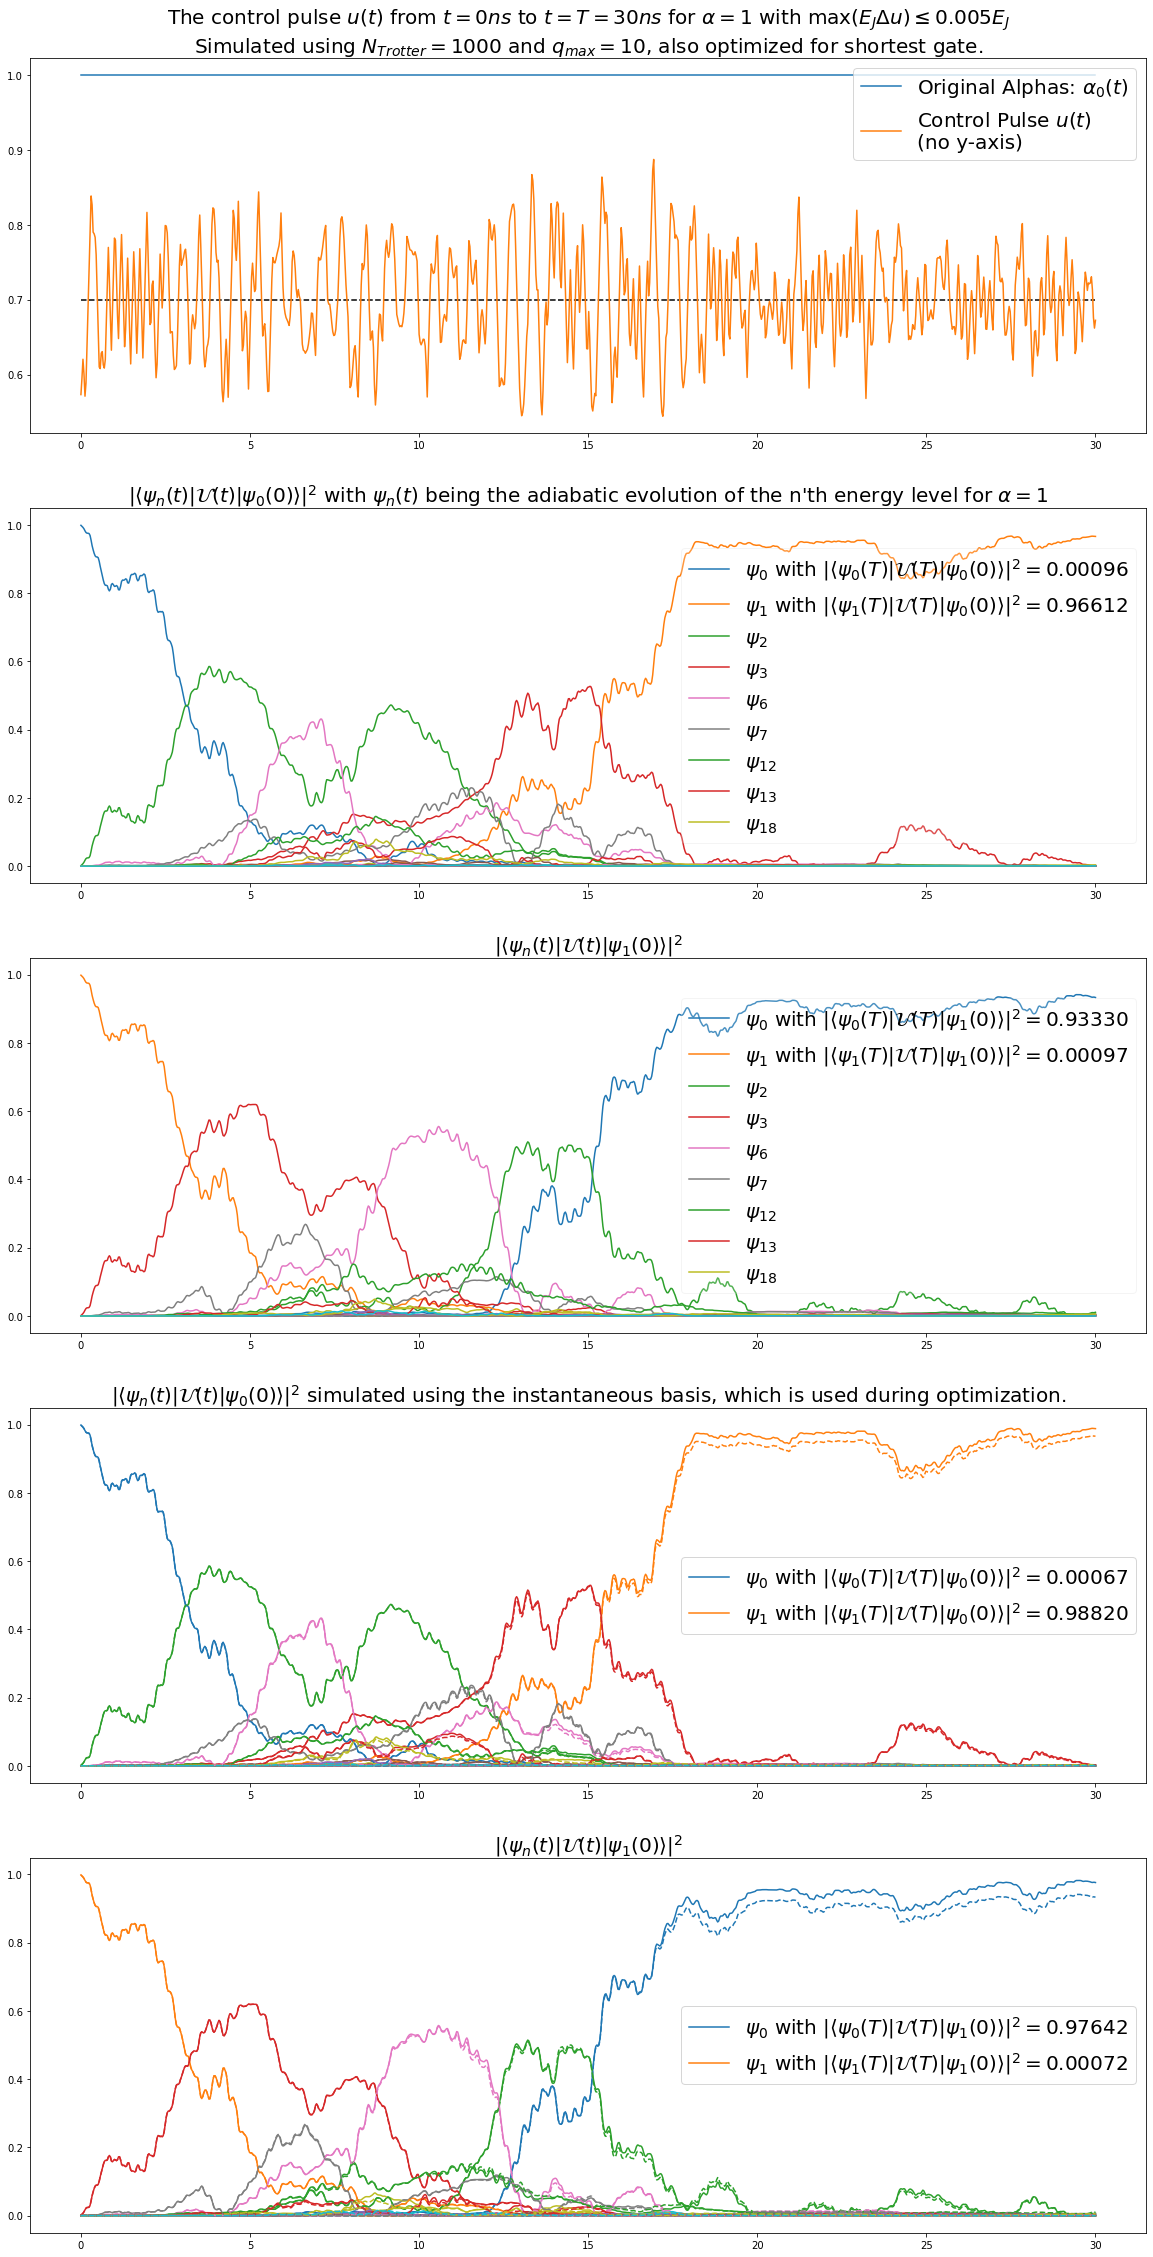

In [286]:
fig3 = plot(occQT,occET)

In [275]:
# fig3.savefig("Occupation_figs/ConstrainedPulse_ConstantAlpha_shortXGate.pdf")

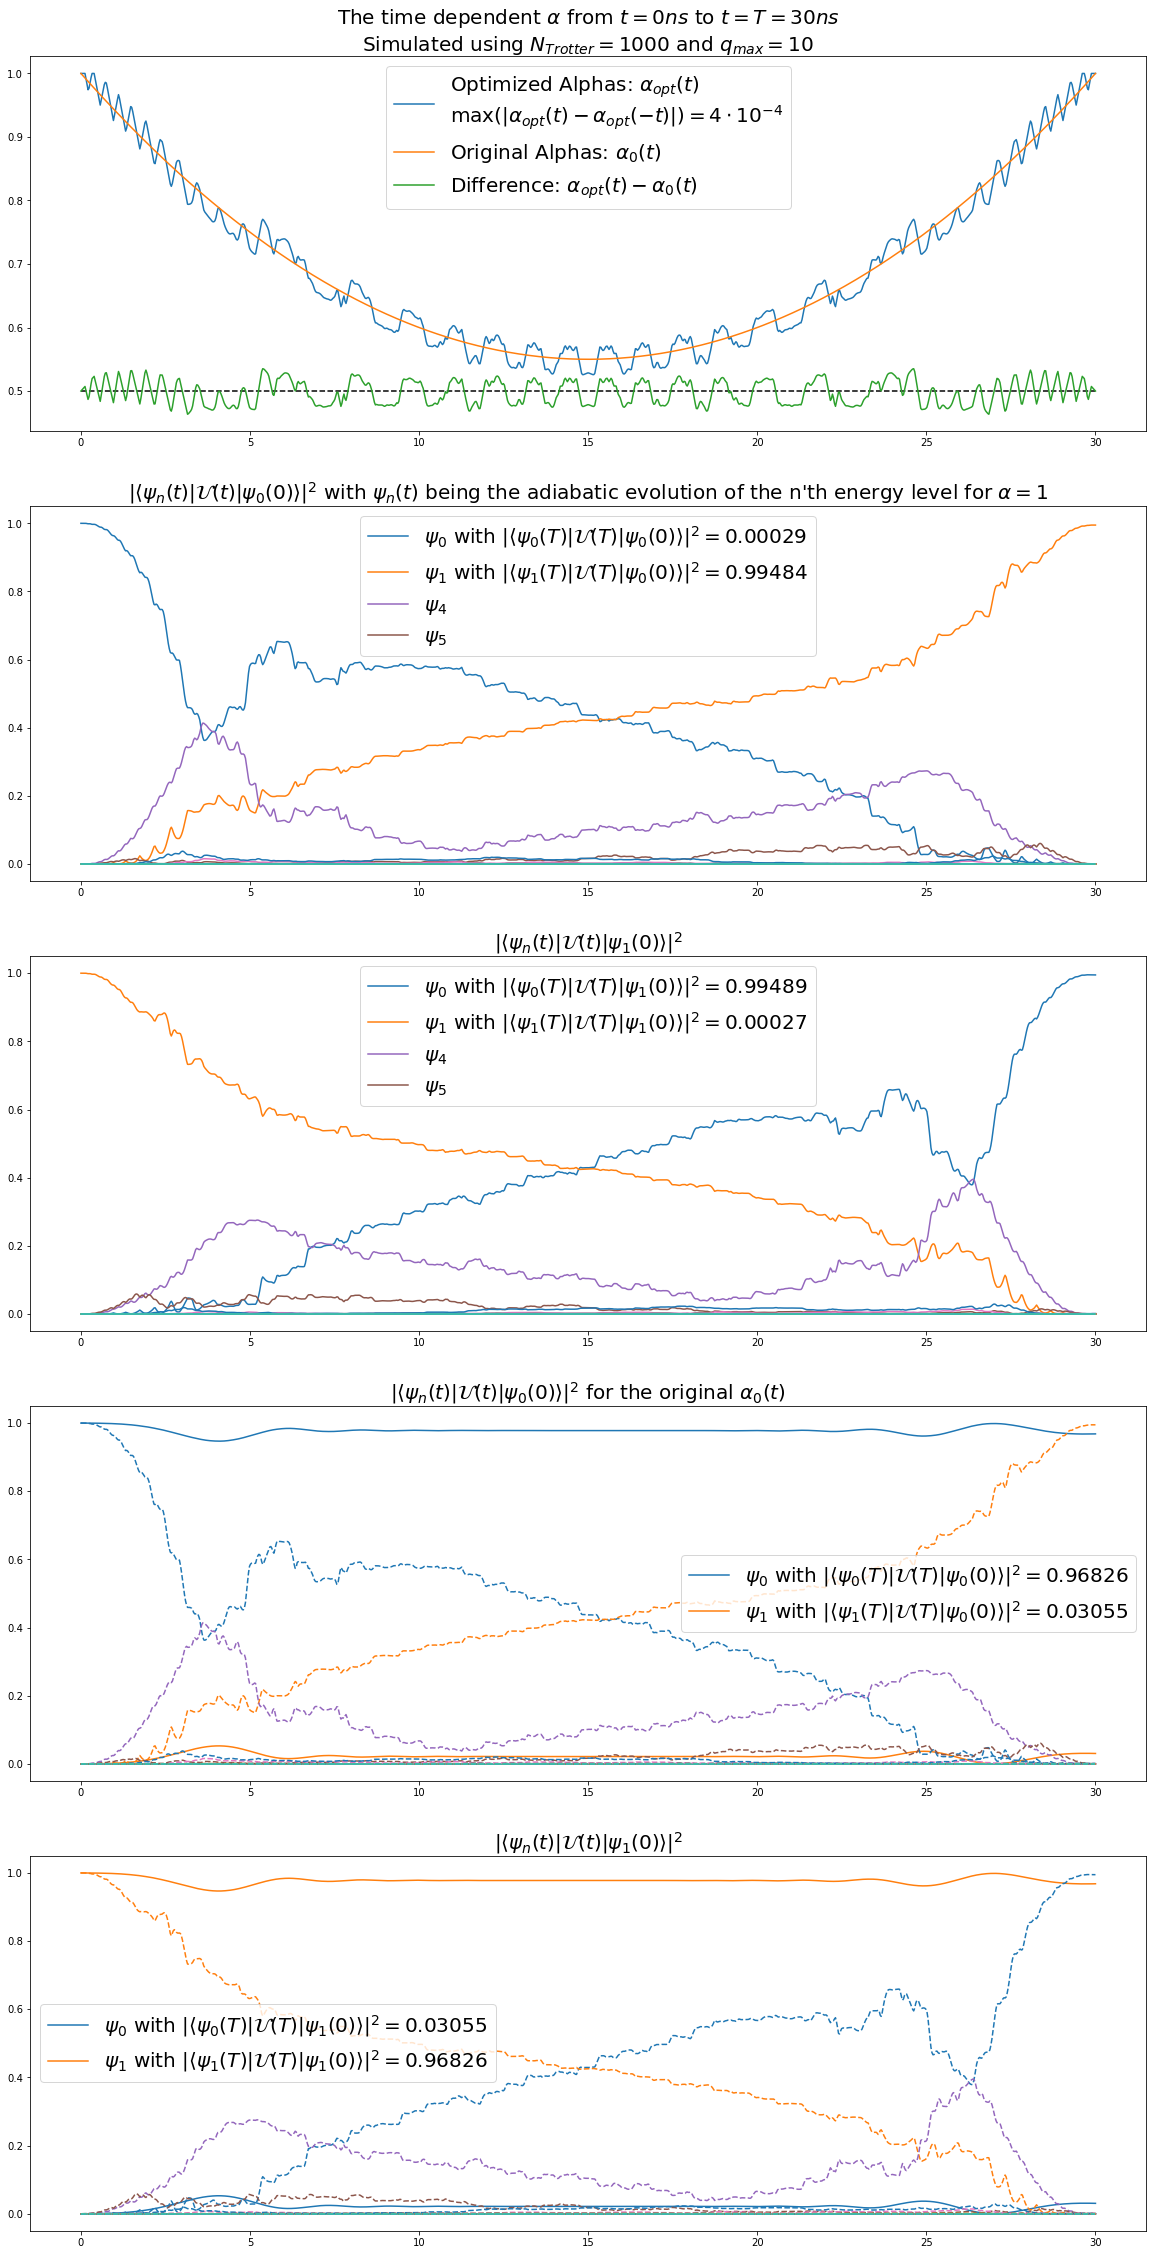

In [171]:
fig2 = plot(occQT,occQT2)

In [172]:
# fig2.savefig("Occupation_figs/SymParabola_AlphaOnly_XGate.pdf")

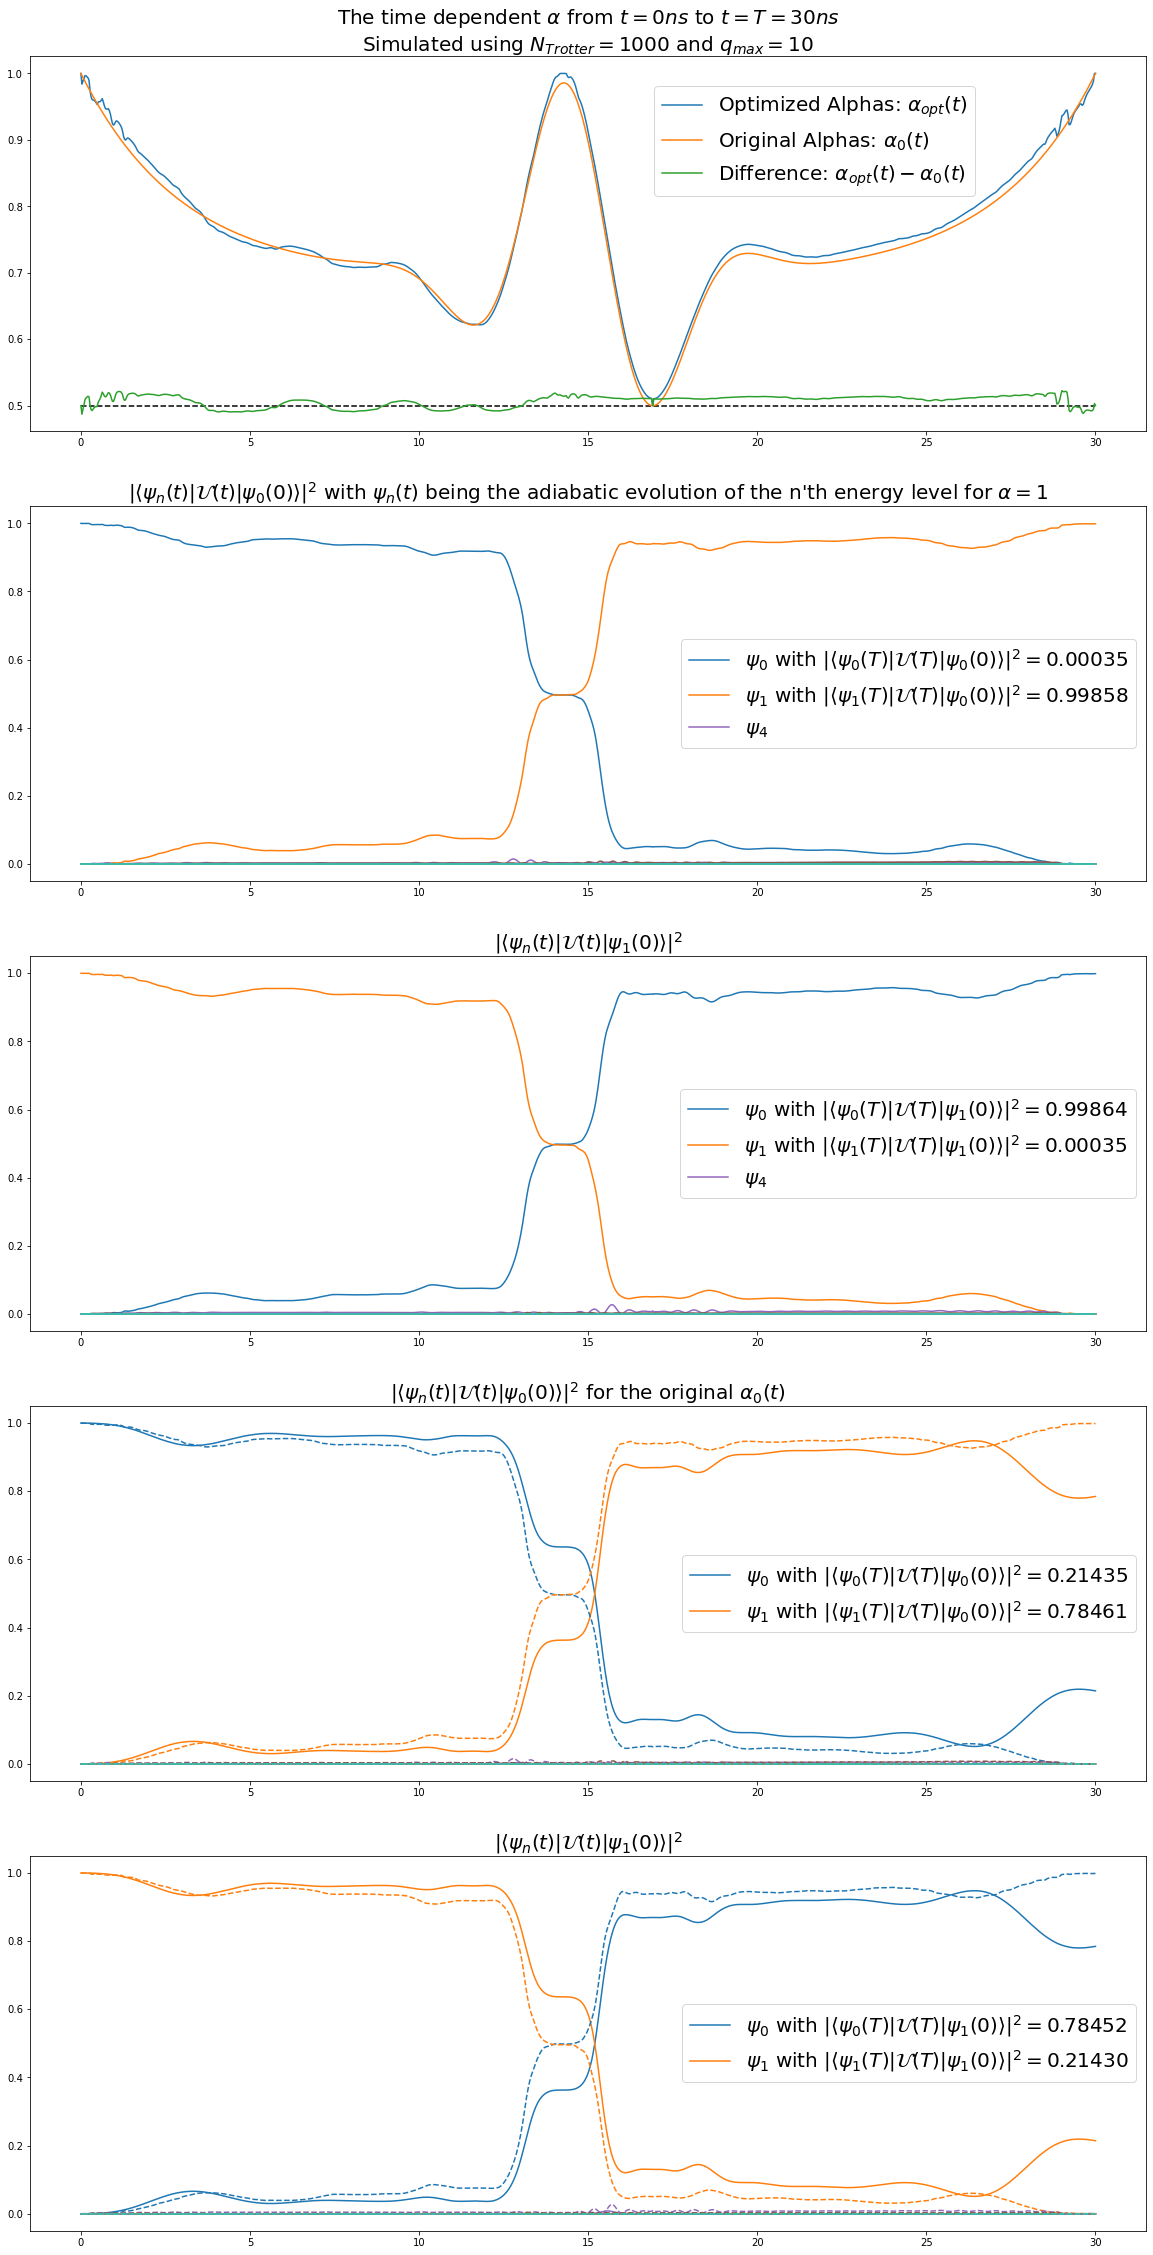

In [146]:
fig1 = plot(occQT,occQT2)

In [147]:
# fig1.savefig("Occupation_figs/GaussSinPeak_AlphaOnly_XGate.pdf")

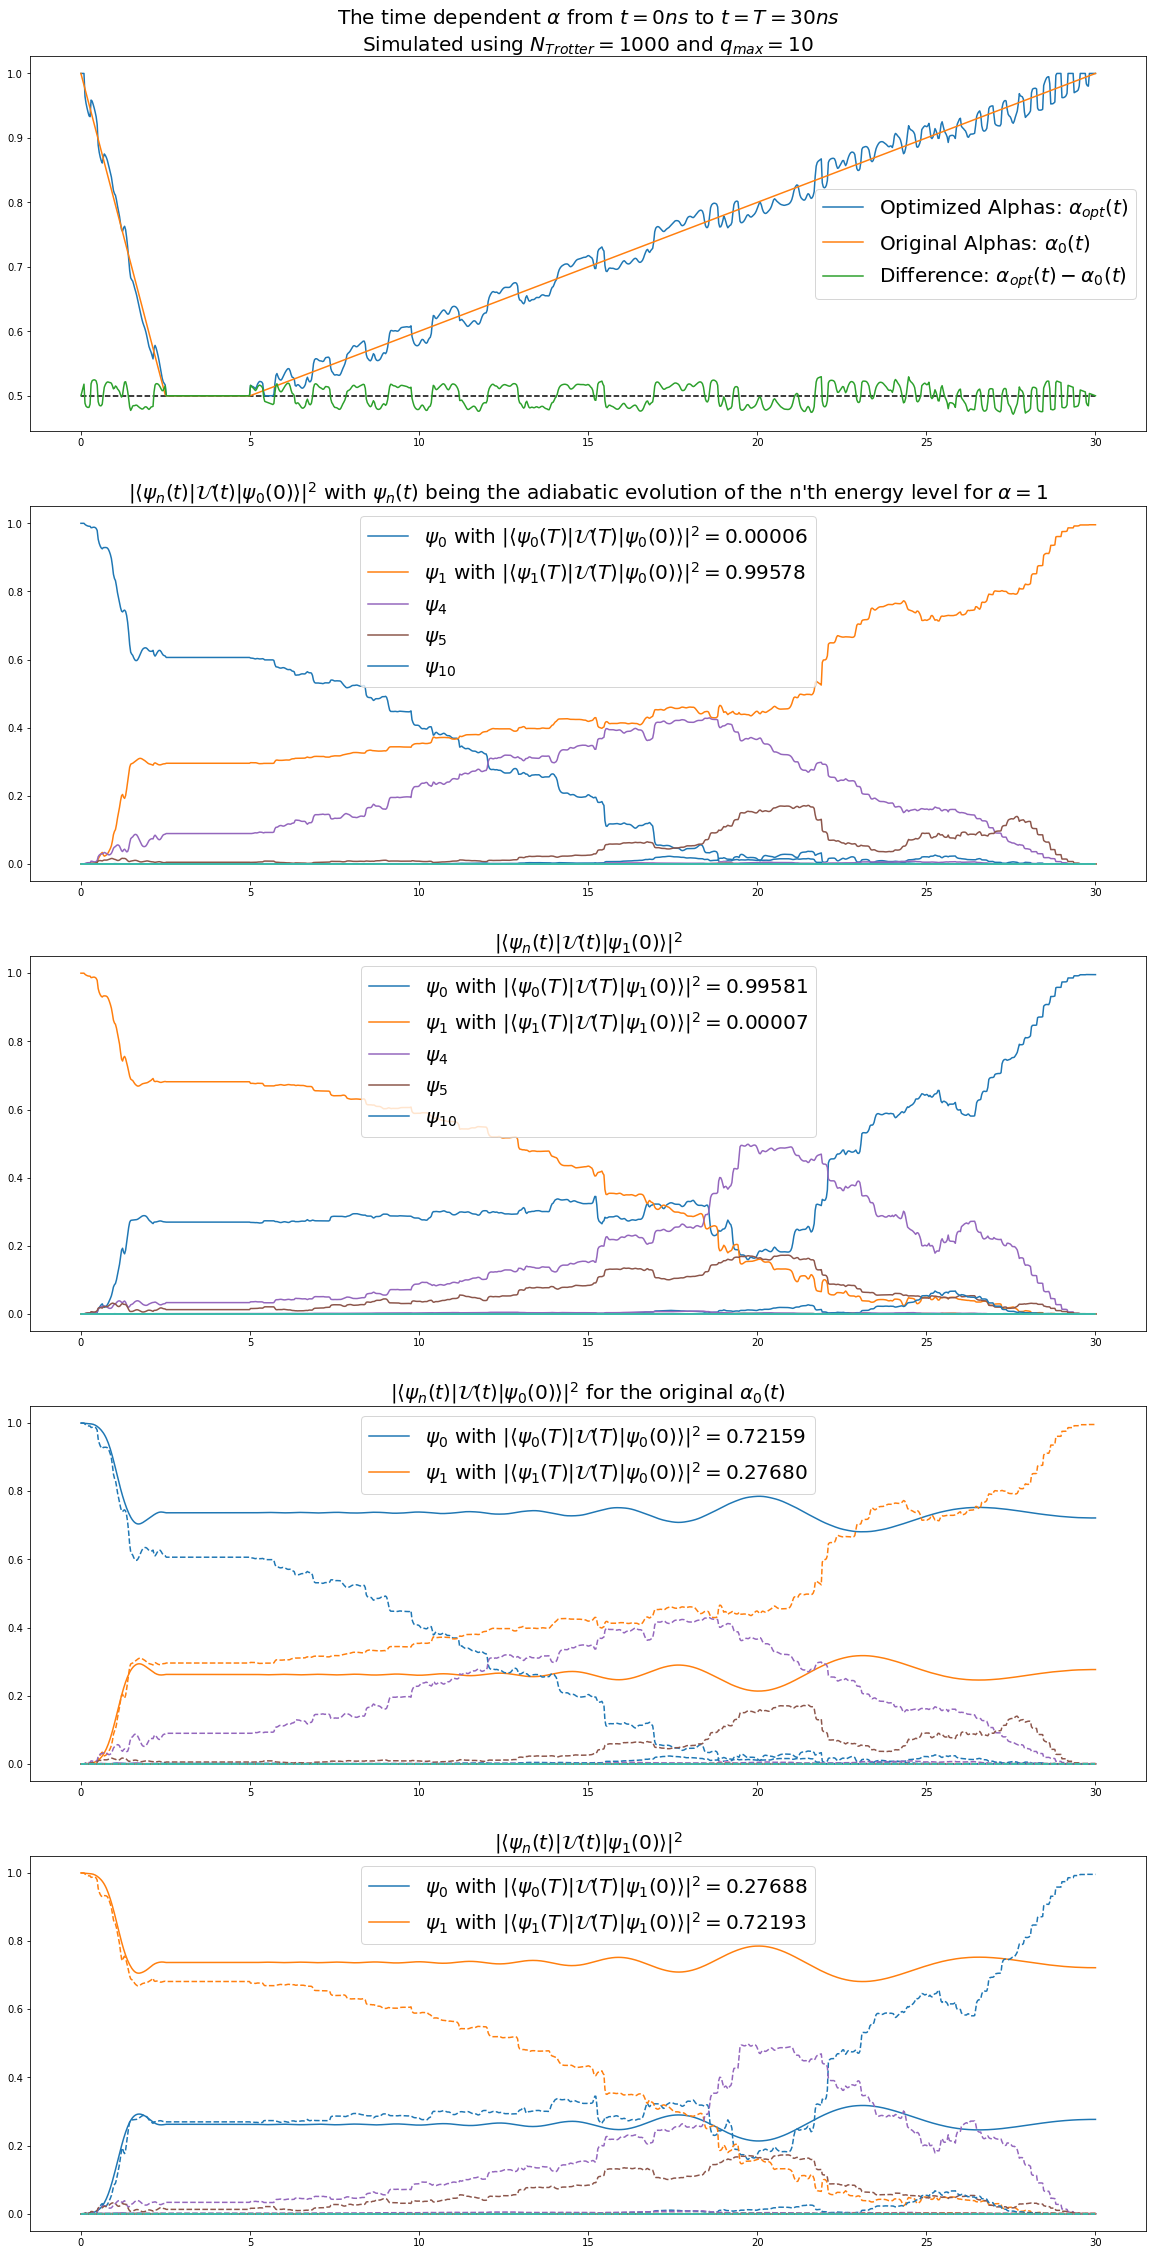

In [118]:
fig0 = plot(occQT,occQT2)

In [119]:
# fig0.savefig("Occupation_figs/AsymLinear_AlphaOnly_XGate.pdf")